In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [11]:
# Reflect the existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(autoload_with=engine)


In [13]:
# View all of the classes that automap found
sorted(Base.classes.keys())


['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Check the most recent date logged (should be '2017-08-23')
print(most_recent_date)


2017-08-23


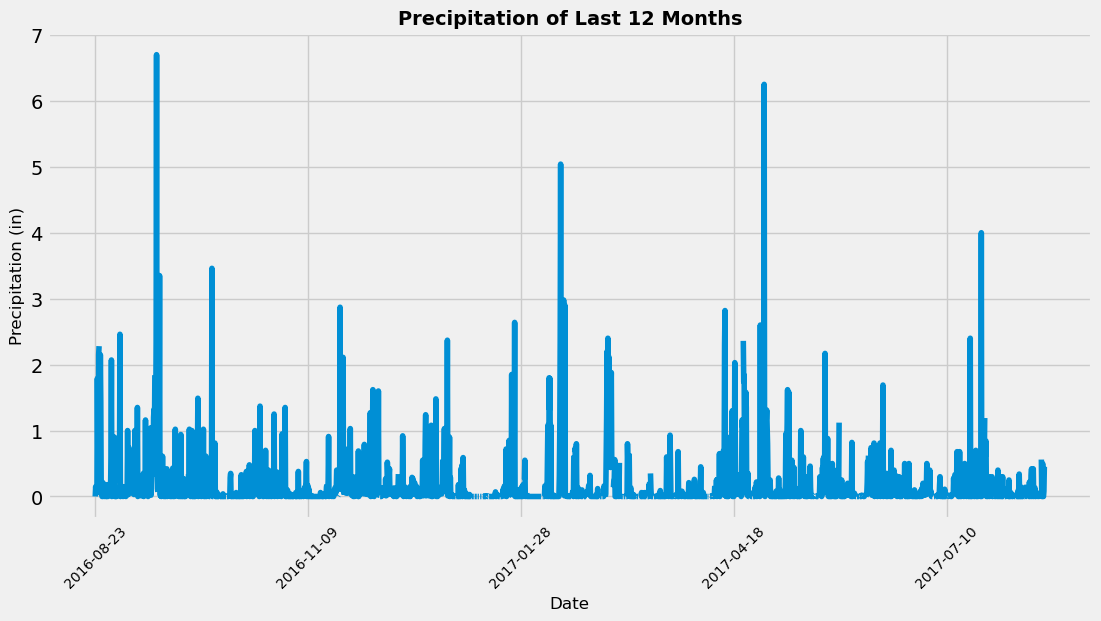

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
    .filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_year_ago.strftime("%Y-%m-%d"))\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(12,6), rot=90)
plt.xticks(fontsize=10, rotation=45)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (in)", fontsize=12)
plt.title("Precipitation of Last 12 Months", fontsize=14, fontweight="bold")
plt.legend().remove()
plt.show()


In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Convert precipitation column to numeric and drop NaN values
df['precipitation'] = pd.to_numeric(df['precipitation'], errors='coerce')
df.dropna(inplace=True)

# Print the summary statistics
df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
print(f"Total stations: {station_count}")


Total stations: 9


In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
        Measurement.station, func.count(Measurement.station)
    )\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# Get the station with the most observations
most_active_station = active_stations[0][0]

# Print all active stations with their observation counts
print("Most active stations (sorted by observation count):")
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")


Most active stations (sorted by observation count):
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

print(f"Temp stats: Min={temp_stats[0][0]}, Max={temp_stats[0][2]}, Avg={temp_stats[0][1]},")


Temp stats: Min=54.0, Max=85.0, Avg=71.66378066378067,


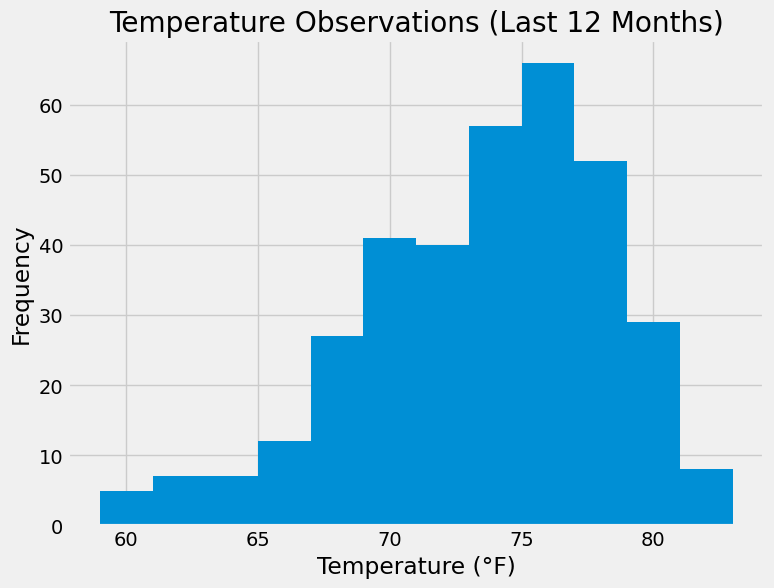

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_ago).all()

tobs_df = pd.DataFrame(tobs_data, columns=['tobs'])

# Plot histogram
tobs_df.plot.hist(bins=12, figsize=(8,6))
plt.xlabel("Temperature (\u00b0F)")
plt.ylabel("Frequency")
plt.title("Temperature Observations (Last 12 Months)")
plt.legend().remove()
plt.show()


# Close Session

In [36]:
# Close Session
session.close()
